In [1]:
import pandas as pd # таблицы
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
from datetime import datetime
from datetime import date
import plotly.express as px
import numpy as np
import seaborn as sns
import math
import statistics
import scipy.stats
import configparser

config = configparser.ConfigParser()
a = config.read('../../config.ini')

import sys
sys.path.append('../..')

pd.options.mode.chained_assignment = None  # без этого что-то внизу не работаетF


In [2]:
!pip install plotly

In [3]:
sbr_intercom = pd.read_csv('data.csv', sep=';' ) # загружаем данные из  файла csv, с разделителм ";"

In [4]:
ad = sbr_intercom 

In [5]:
ad.info() #Оценка столбцов/поиск недостающих значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62680 entries, 0 to 62679
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         62680 non-null  int64 
 1   dt_active  62680 non-null  object
dtypes: int64(1), object(1)
memory usage: 979.5+ KB


два поля  id  типа int64 и dt_active object

In [6]:
ad.isnull().sum()# Поиск пропущенных значений

id           0
dt_active    0
dtype: int64

нет пропущенных значений

In [7]:
ad.describe() #

,id
count,6.268000e+04
mean,3.725500e+08
std,3.625116e+06
min,3.663192e+08
25%,3.693584e+08
50%,3.724129e+08
75%,3.756691e+08
max,3.790245e+08


в нашем случае ничего ценного не показывает

In [8]:
sbr_intercom.columns=['id','time']# меняем название 
sbr_intercom=sbr_intercom. sort_values(by = 'time', ascending = True).reset_index() # сортируем по времени, индексируем строки 

In [9]:
sbr_intercom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62680 entries, 0 to 62679
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   62680 non-null  int64 
 1   id      62680 non-null  int64 
 2   time    62680 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [10]:
sbr_intercom['time'] = pd.to_datetime(sbr_intercom['time']) #преобразвываем object в  datetime64
sbr_intercom['time']=sbr_intercom['time'].dt.strftime('%x') ##преобразвываем
sbr_intercom['count']=sbr_intercom.groupby('time')['id'].transform('nunique')#группируем по  полю  time  и добавлеям поле "count"
sbr_intercom['time'] = pd.to_datetime(sbr_intercom['time'])#преобразвываем

In [11]:
sbr_intercom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62680 entries, 0 to 62679
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   62680 non-null  int64         
 1   id      62680 non-null  int64         
 2   time    62680 non-null  datetime64[ns]
 3   count   62680 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.9 MB


In [12]:
df_intercom=sbr_intercom[['time','count']]
df_intercom=df_intercom.drop_duplicates()# устранение дубликато набор данных
df_intercom=df_intercom.rename(columns={'time':'ds', 'count':'y'})
df_intercom=df_intercom.sort_values(by='ds').reset_index(drop=True)
df_intercom=df_intercom.reset_index()

In [13]:
df_intercom.head(2)

,index,ds,y
0,0,2017-01-11,2131
1,1,2017-02-11,2243


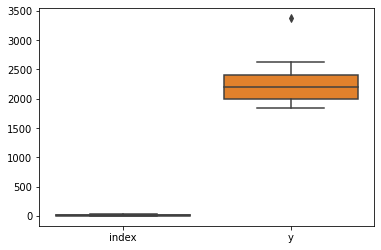

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_intercom)

В данных имеется выбос, вероятно был сьой систем и клиенты  обращались в поддержку больше чем обычно

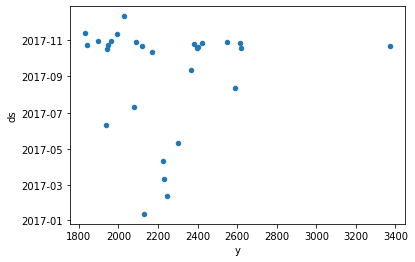

In [15]:
df_intercom.plot(x='y', y='ds', kind='scatter')

На точечном графике показана слабая  отрицательная корреляция 

In [16]:
import datetime
df_intercom['ds_ordinal'] = pd.to_datetime(df_intercom.ds, format="%Y%M%D")
df_intercom['ds_ordinal'] = df_intercom['ds_ordinal'].map(datetime.datetime.toordinal)

In [17]:
df_intercom['weekday']=df_intercom['ds'].dt.strftime('%A')

In [18]:
df_intercom.head(2)

,index,ds,y,ds_ordinal,weekday
0,0,2017-01-11,2131,736340,Wednesday
1,1,2017-02-11,2243,736371,Saturday


In [19]:
def weekdays(row):
    weekday=row.weekday
    if weekday=='Thursday' :
        return '-0.107205'
    if weekday=='Friday' :
        return '-0.034104'
    if weekday=='Saturday' :
        return '0.177063'
    if weekday=='Sunday' :
        return '0.155909'
    if weekday=='Monday' :
        return '-0.053048'
    if weekday=='Tuesday' :
        return '-0.004877'
    if weekday=='Wednesday' :
        return '-0.066004'
        
df_intercom['koeff']=df_intercom.apply (lambda row: weekdays(row), axis=1)# дню неделю присваем  данные для получния коэфициента, данные 

In [20]:
df_intercom['koeff']=df_intercom['koeff'].astype('float')
df_intercom.head(2)

,index,ds,y,ds_ordinal,weekday,koeff
0,0,2017-01-11,2131,736340,Wednesday,-0.066004
1,1,2017-02-11,2243,736371,Saturday,0.177063


In [21]:
df_intercom['smooth_y']=df_intercom.y+(df_intercom.y*df_intercom.koeff)


In [22]:
df_intercom['smooth_p']=(df_intercom.smooth_y)/(13)/(8)# предположим, что норма в час 13 шт, 8 часво работы одного человека
df_intercom.head(2)

,index,ds,y,ds_ordinal,weekday,koeff,smooth_y,smooth_p
0,0,2017-01-11,2131,736340,Wednesday,-0.066004,1990.345476,19.137937
1,1,2017-02-11,2243,736371,Saturday,0.177063,2640.152309,25.386080


In [23]:
df_intercom.describe()

,index,y,ds_ordinal,koeff,smooth_y,smooth_p
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,13.500000,2238.571429,736575.500000,0.013410,2270.723051,21.833875
std,8.225975,326.675445,92.889221,0.104390,435.615090,4.188607
min,0.000000,1832.000000,736340.000000,-0.107205,1734.816064,16.680924
25%,6.750000,1987.250000,736544.250000,-0.056287,1981.364500,19.051582
50%,13.500000,2196.500000,736622.500000,-0.034104,2233.184436,21.472927
75%,20.250000,2398.750000,736629.250000,0.155909,2432.247155,23.386992
max,27.000000,3370.000000,736674.000000,0.177063,3895.413330,37.455897


In [24]:
df_intercom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       28 non-null     int64         
 1   ds          28 non-null     datetime64[ns]
 2   y           28 non-null     int64         
 3   ds_ordinal  28 non-null     int64         
 4   weekday     28 non-null     object        
 5   koeff       28 non-null     float64       
 6   smooth_y    28 non-null     float64       
 7   smooth_p    28 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 1.9+ KB


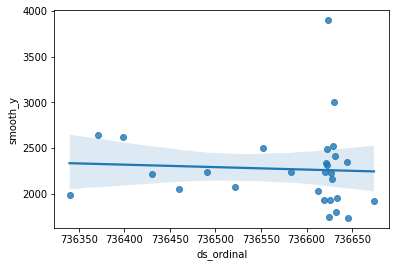

In [25]:
sns.regplot(x="ds_ordinal", y="smooth_y", data=df_intercom)

In [26]:
df_intercom['ds_ordinal'].corr(df_intercom['smooth_y'])# расчет кореляции

-0.057412106591733555

На  графике  и расчет показал слабая корреляция данных  -0.057412106591733555

In [27]:
fact = pd.read_csv('fact.csv', sep=';' ) # загружаем данные из  файла csv, с разделителм ";"

In [28]:
fact

,ds,y_i
0,12.01.2017,2218.523
1,12.02.2017,1759.832
2,12.03.2017,1989.130
3,12.04.2017,2219.238
4,12.05.2017,2300.771
5,12.06.2017,2193.764
6,12.07.2017,2222.985
7,12.08.2017,2177.574
8,12.09.2017,1957.281
9,12.10.2017,1694.539


In [29]:
fact['y_i'].astype('float')


0     2218.523
1     1759.832
2     1989.130
3     2219.238
4     2300.771
5     2193.764
6     2222.985
7     2177.574
8     1957.281
9     1694.539
10    2163.255
11    3000.877
12    2121.755
13    2387.898
Name: y_i, dtype: float64

In [30]:
fact['smooth_I']=fact['y_i']/(13)/(8)# предположим, что норма в час 13 шт, 8 часво работы одного человека

In [31]:
fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ds        14 non-null     object 
 1   y_i       14 non-null     float64
 2   smooth_I  14 non-null     float64
dtypes: float64(2), object(1)
memory usage: 464.0+ bytes


Расчитываем прогноз

In [32]:
dates=df_intercom['ds_ordinal']
dates = np.array(dates).reshape((len(dates), 1))#изменяем  форму массива

In [33]:
data=df_intercom['smooth_p']
data = np.array(data).reshape((len(data), 1))#изменяем  форму массива

In [34]:
from sklearn import linear_model 
X=dates
y=data
lm = linear_model.LinearRegression()
model = lm.fit(X,y)# метод наименьших квадратов Линейная регрессия.

In [35]:
def date_generator():
  from_date =  datetime.datetime(2017,12, 1)
  while True:
    yield from_date
    from_date = from_date+datetime.timedelta(days=1)

In [36]:
import itertools
future_dates = itertools.islice(date_generator(), 14)  # генирируем новые даты
future_dates=list(future_dates)

In [37]:
from pandas import DataFrame
future = DataFrame(future_dates,columns=['future_dates'])

In [38]:
future['weekday']=future['future_dates'].dt.strftime('%A')

In [39]:
future['future_dates_ordinal'] = pd.to_datetime(future.future_dates, format="%Y%M%D") 
future['future_dates_ordinal'] = future['future_dates_ordinal'].map(datetime.datetime.toordinal)  #создаемн овый столюец с порядковый ноиером 

In [40]:
future_dates_for_model=future['future_dates_ordinal']
future_dates_for_model = np.array(future_dates_for_model).reshape((len(future_dates), 1))

In [41]:
future_2_weeks_predictions = lm.predict(future_dates_for_model)

In [42]:
df_predict = pd.DataFrame(data=future_2_weeks_predictions, columns=["predict"])

In [43]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   predict  14 non-null     float64
dtypes: float64(1)
memory usage: 240.0 bytes


In [44]:
df_predict=pd.concat([df_predict, future], axis=1)
df_predict=df_predict.T.drop_duplicates().T

In [45]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   predict               14 non-null     object        
 1   future_dates          14 non-null     datetime64[ns]
 2   weekday               14 non-null     object        
 3   future_dates_ordinal  14 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 576.0+ bytes


In [46]:
def weekdays(row):
    weekday=row.weekday
    if weekday=='Thursday' :
        return '-0.107205'
    if weekday=='Friday' :
        return '-0.034104'
    if weekday=='Saturday' :
        return '0.177063'
    if weekday=='Sunday' :
        return '0.155909'
    if weekday=='Monday' :
        return '-0.053048'
    if weekday=='Tuesday' :
        return '-0.004877'
    if weekday=='Wednesday' :
        return '-0.066004'
        
df_predict['koeff']=df_predict.apply (lambda row: weekdays(row), axis=1)

In [47]:
df_predict['future_dates'] = pd.to_datetime(df_predict['future_dates'] )
df_predict['future_dates']=df_predict['future_dates'].dt.strftime('%x')

In [48]:
df_predict['koeff']=df_predict['koeff'].astype('float')
df_predict['predict'] = df_predict['predict'].astype('float')

In [49]:
df_predict['final_predictions']=df_predict.predict-(df_predict.predict*df_predict.koeff)

In [50]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   predict               14 non-null     float64
 1   future_dates          14 non-null     object 
 2   weekday               14 non-null     object 
 3   future_dates_ordinal  14 non-null     object 
 4   koeff                 14 non-null     float64
 5   final_predictions     14 non-null     float64
dtypes: float64(3), object(3)
memory usage: 800.0+ bytes


In [51]:
df_predict

,predict,future_dates,weekday,future_dates_ordinal,koeff,final_predictions
0,21.604762,12/01/17,Friday,736664,-0.034104,22.341571
1,21.602173,12/02/17,Saturday,736665,0.177063,17.777227
2,21.599584,12/03/17,Sunday,736666,0.155909,18.232015
3,21.596995,12/04/17,Monday,736667,-0.053048,22.742673
4,21.594406,12/05/17,Tuesday,736668,-0.004877,21.699722
5,21.591818,12/06/17,Wednesday,736669,-0.066004,23.016964
6,21.589229,12/07/17,Thursday,736670,-0.107205,23.903702
7,21.586640,12/08/17,Friday,736671,-0.034104,22.322831
8,21.584051,12/09/17,Saturday,736672,0.177063,17.762314
9,21.581462,12/10/17,Sunday,736673,0.155909,18.216718


In [52]:
df_s= df_predict.join(fact)

In [53]:
df_s

,predict,future_dates,weekday,future_dates_ordinal,koeff,final_predictions,ds,y_i,smooth_I
0,21.604762,12/01/17,Friday,736664,-0.034104,22.341571,12.01.2017,2218.523,21.331952
1,21.602173,12/02/17,Saturday,736665,0.177063,17.777227,12.02.2017,1759.832,16.921462
2,21.599584,12/03/17,Sunday,736666,0.155909,18.232015,12.03.2017,1989.130,19.126250
3,21.596995,12/04/17,Monday,736667,-0.053048,22.742673,12.04.2017,2219.238,21.338827
4,21.594406,12/05/17,Tuesday,736668,-0.004877,21.699722,12.05.2017,2300.771,22.122798
5,21.591818,12/06/17,Wednesday,736669,-0.066004,23.016964,12.06.2017,2193.764,21.093885
6,21.589229,12/07/17,Thursday,736670,-0.107205,23.903702,12.07.2017,2222.985,21.374856
7,21.586640,12/08/17,Friday,736671,-0.034104,22.322831,12.08.2017,2177.574,20.938212
8,21.584051,12/09/17,Saturday,736672,0.177063,17.762314,12.09.2017,1957.281,18.820010
9,21.581462,12/10/17,Sunday,736673,0.155909,18.216718,12.10.2017,1694.539,16.293644


In [54]:
df_s.describe()

,predict,koeff,final_predictions,y_i,smooth_I
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,21.587934,0.009676,21.378723,2171.958714,20.884218
std,0.010830,0.107313,2.313609,308.561076,2.966933
min,21.571107,-0.107205,17.762314,1694.539000,16.293644
25%,21.579520,-0.062765,19.094389,2022.286250,19.445060
50%,21.587934,-0.034104,22.332201,2185.669000,21.016048
75%,21.596348,0.115712,22.933902,2222.048250,21.365849
max,21.604762,0.177063,23.903702,3000.877000,28.854587


In [55]:
df_s_m = df_s[['ds','weekday','final_predictions','smooth_I']]

In [56]:
df_s_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ds                 14 non-null     object 
 1   weekday            14 non-null     object 
 2   final_predictions  14 non-null     float64
 3   smooth_I           14 non-null     float64
dtypes: float64(2), object(2)
memory usage: 576.0+ bytes


In [57]:
df_s_m.corr()

,final_predictions,smooth_I
final_predictions,1.000000,0.578089
smooth_I,0.578089,1.000000


In [58]:
df_s_m.corr(method='spearman')

,final_predictions,smooth_I
final_predictions,1.000000,0.569231
smooth_I,0.569231,1.000000


Проверили гипотезу, что в выходные надо  меньше  людей, чем в будни.

H0 В выходные надо меншье людей, чем в будни 
H1 В будни надо  меньше людей , чем в будни

In [59]:
alpha = 0.05  
df_g = st.ttest_ind(df_intercom[df_intercom['weekday'] == 'Sunday']['smooth_p'], df_intercom[df_intercom['weekday'] == 'Monday']['smooth_p'], equal_var=False)
print(df_g)
if (df_g.pvalue < alpha):
    print('Отвергаем Н0 гипотезу. В будни надо меншье людей, чем в выходные ')
else:
    print('Не отвергаем Н0 гипотезу. В выходные надо  меньше людей, чем в будни')

Ttest_indResult(statistic=1.804186409390875, pvalue=0.20515437793142147)
Не отвергаем Н0 гипотезу. В выходные надо  меньше людей, чем в будни


In [60]:
fig_2 = px.line(df_predict, x="future_dates", y="final_predictions", title='Людей на звонках по дням - прогноз')
fig_2.show()

In [61]:
fig_1 = px.line(df_s_m, x="ds", y="smooth_I", title='Людей на звонках по дням - факт')
fig_1.show()

In [72]:
import plotly.express as px
import plotly.graph_objects as go

fig1 = px.line(fact, x='ds', y='smooth_I')
fig2 = px.line(df_predict, x='future_dates', y='final_predictions')

fig = go.Figure(data = fig1.data + fig2.data)
fig.show()

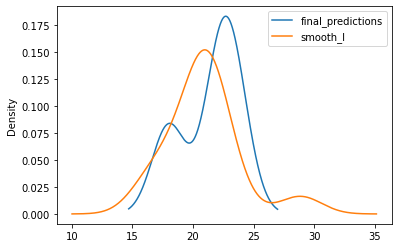

In [63]:
ax =df_s_m.plot.kde()

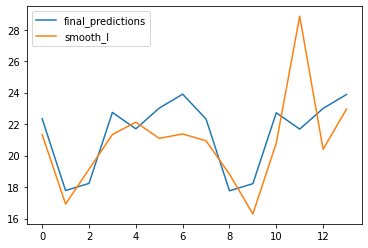

In [64]:
lines = df_s_m.plot.line()

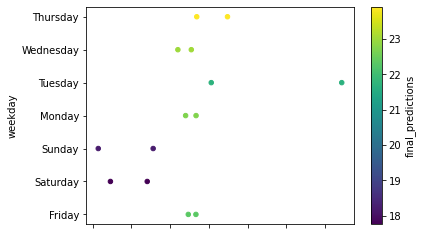

In [65]:
ax2 = df_s_m.plot.scatter(x='smooth_I',
                      y='weekday',
                      c='final_predictions',
                      colormap='viridis')

,final_predictions,smooth_I
count,14.000000,14.000000
mean,21.378723,20.884218
std,2.313609,2.966933
min,17.762314,16.293644
25%,19.094389,19.445060
50%,22.332201,21.016048
75%,22.933902,21.365849
max,23.903702,28.854587


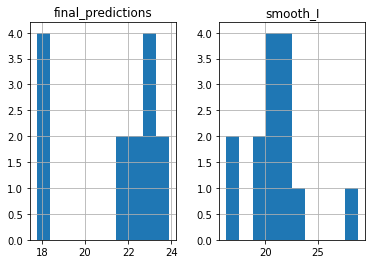

In [66]:
itog =  df_s_m.describe()
df_s_m.hist()
itog

In [67]:
from scipy.stats import variation 
var = variation(itog['final_predictions'], axis=0)
idmax = np.argmax(var)
print(idmax)

0


Как можно заметить из характеристик и гистограммы, ряд у нас не однородный и имеет разброс о чем свидетельствует  коэффициент вариации равный  0

In [69]:
final_predictions=df_predict[['future_dates','final_predictions']]
final_predictions

,future_dates,final_predictions
0,12/01/17,22.341571
1,12/02/17,17.777227
2,12/03/17,18.232015
3,12/04/17,22.742673
4,12/05/17,21.699722
5,12/06/17,23.016964
6,12/07/17,23.903702
7,12/08/17,22.322831
8,12/09/17,17.762314
9,12/10/17,18.216718


In [70]:
writer = pd.ExcelWriter('итог.xlsx')
final_predictions.to_excel(writer, sheet_name='bar')
writer.save()